<a href="https://colab.research.google.com/github/martell-n-tardy/Risk-Prediction-Models-for-Type-2-Diabetes/blob/main/Features_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Feature Selection: BRFSS data - By Martell Tardy, M.S.**

# Load packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
!pip uninstall pandas
!pip install pandas==1.1.5

Found existing installation: pandas 1.1.5
Uninstalling pandas-1.1.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.1.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.1.5
     |████████████████████████████████| 9.5 MB 7.7 MB/s 


# Load data

In [ ]:
#mount Drive and grant access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read in data and save as variable df
df = pd.read_csv('/content/drive/MyDrive/SPRINGBOARD/CAPSTONE 3/BRFSS Data/Interim/manualfs_2015.csv')

In [ ]:
df

,_STATE,PHYSHLTH,MENTHLTH,POORHLTH,HLTHPLN1,PERSDOC2,MEDCOST,CHECKUP1,BPMEDS,CHOLCHK,CVDINFR4,CVDCRHD4,CVDSTRK3,CHCSCNCR,CHCOCNCR,CHCCOPD1,ADDEPEV2,CHCKIDNY,DIABETE3,DIABAGE2,SEX,MARITAL,RENTHOM1,NUMHHOL2,CPDEMO1,VETERAN3,EMPLOY1,INTERNET,PREGNANT,QLACTLM2,USEEQUIP,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,STOPSMK2,LASTSMK2,USENOW3,ALCDAY5,...,_RFCHOL,_MICHD,_ASTHMS1,_DRDXAR1,_RACE,_AGEG5YR,HTIN4,_BMI5CAT,_CHLDCNT,_EDUCAG,_INCOMG,_SMOKER3,DROCDY3_,_DRNKWEK,_RFDRHV5,FTJUDA1_,FRUTDA1_,BEANDAY_,GRENDAY_,ORNGDAY_,VEGEDA1_,_FRTLT1,_VEGLT1,_TOTINDA,ACTIN11_,ACTIN21_,STRFREQ_,_PACAT1,_PAINDX1,_PA150R2,_PA300R2,_PA30021,_PASTRNG,_PAREC1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_AIDTST3,TYPE2
0,1.0,15.0,18.0,10.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,3.0,99.0,2.0,1.0,1.0,2.0,1.0,2.0,8.0,2.0,9.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0,2.0,3.0,888.0,...,2.0,2.0,1.0,1.0,1.0,9.0,70.0,4.0,1.0,2.0,2.0,3.0,5.397605e-79,5.397605e-79,1.0,1.700000e+01,3.300000e+01,6.700000e+01,3.300000e+01,17.0,100.0,2.0,1.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,0
1,1.0,88.0,88.0,99.0,2.0,1.0,1.0,4.0,9.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,99.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,1.0,9.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,99.0,3.0,888.0,...,1.0,2.0,3.0,2.0,1.0,7.0,68.0,3.0,1.0,4.0,1.0,1.0,5.397605e-79,5.397605e-79,1.0,7.000000e+00,1.700000e+01,7.000000e+00,2.900000e+01,29.0,13.0,2.0,2.0,1.0,1.0,5.397605e-79,5.397605e-79,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,2.0,2.0,0
2,1.0,15.0,88.0,88.0,1.0,2.0,2.0,1.0,9.0,1.0,7.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,3.0,99.0,2.0,2.0,1.0,2.0,1.0,2.0,7.0,2.0,9.0,2.0,2.0,2.0,2.0,9.0,9.0,9.0,9.0,99.0,9.0,999.0,...,2.0,9.0,3.0,1.0,1.0,11.0,71.0,2.0,1.0,2.0,9.0,9.0,9.000000e+02,9.990000e+04,9.0,9.999000e+04,9.999000e+04,9.999000e+04,9.999000e+04,99990.0,99990.0,9.0,9.0,9.0,9.0,9.000000e+00,9.900000e+04,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,0
3,1.0,30.0,30.0,30.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,3.0,99.0,2.0,1.0,1.0,2.0,1.0,2.0,8.0,2.0,9.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,9.0,99.0,3.0,888.0,...,2.0,2.0,3.0,1.0,1.0,9.0,67.0,3.0,2.0,2.0,5.0,4.0,5.397605e-79,5.397605e-79,1.0,5.397605e-79,1.000000e+02,5.397605e-79,3.000000e+00,3.0,14.0,1.0,2.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,9.0,0
4,1.0,20.0,88.0,30.0,1.0,1.0,2.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,99.0,2.0,1.0,1.0,2.0,2.0,2.0,8.0,1.0,9.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,99.0,3.0,888.0,...,1.0,2.0,3.0,1.0,1.0,9.0,64.0,2.0,1.0,3.0,9.0,4.0,5.397605e-79,5.397605e-79,1.0,9.999000e+04,2.000000e+02,4.300000e+01,5.700000e+01,33.0,67.0,9.0,1.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,88.0,88.0,99.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,55.0,2.0,3.0,1.0,9.0,9.0,2.0,7.0,2.0,9.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,9.0,99.0,3.0,888.0,...,2.0,2.0,3.0,1.0,8.0,11.0,63.0,1.0,1.0,1.0,2.0,4.0,5.397605e-79,5.397605e-79,1.0,2.900000e+01,5.397605e-79,7.100000e+01,5.397605e-79,14.0,14.0,2.0,2.0,2.0,9.0,9.000000e+00,5.397605e-79,4.0,2.0,3.0,3.0,2.0,2.0,4.0,2.0,2.0,3.0,1.0,2.0,1
441452,72.0,88.0,88.0,99.0,1.0,1.0,2.0,1.0,9.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,99.0,2.0,1.0,1.0,9.0,9.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,99.0,3.0,888.0,...,1.0,2.0,3.0,2.0,8.0,2.0,63.0,3.0,2.0,3.0,1.0,4.0,5.397605e-79,5.397605e-79,1.0,1.700000e+01,1.000000e+02,2.900000e+01,1.000000e+01,14.0,29.0,1.0,2.0,1.0,1.0,5.397605e-79,5.397605e-79,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,0
441453,72.0,88.0,20.0,88.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,3.0,99.0,2.0,1.0,1.0,9.0,9.0,2.0,7.0,2.0,9

Now, let's confirm again there are no null values in this dataset.

In [ ]:
df.columns[df.isnull().any()]

Index([], dtype='object')

There are no null values. Otherwise the column name would be returned. 

Now, let's turn this into a binary classification problem. Meaning, the survey participants are either diabetic or not diabetic. Those who are diabetic have already been identified and their status saved in dataset as column feature `TYPE2` where those who are diabetic are labeled as value 1 and those who are not as value 0.

# LightGBM Classifier: finalizing feature selection

Now, we will explore the traditional LightGBM method Gradient Boosting Decision Tree (GBDT) to select our final features. This method is based on three important principles: weak learners (decision trees), gradient optimization, and boosting technique. Since this is a binary classification problem, we will be using the Classifier() approach for the algorithm versus Regression().

## preparing the data

We have already identified our target population as feature `TYPE2`. However, we need to identify potential features that are highly correlated with the feature resulting in target leakage. 

In the prior notebook we identified the use of the features `DIABETES3` and `AGEG5YR` to create the target feature, therefore, these features will be removed. Also, 11 features representing questions that were asked only to those who identified as having diabetes will be removed as well. 

In [ ]:
#copy of df as appropriate type for LightGBM
df1 = df

#split data into X and y
X,y = df1.drop(['TYPE2','INSULIN', 'BLDSUGAR','FEETCHK2',	'DOCTDIAB',	'CHKHEMO3',	'FEETCHK',	'EYEEXAM',	'DIABEYE',	'DIABEDU',	'DIABETE3', 'DIABAGE2','PDIABTST'], axis = 1), df1['TYPE2']
#split data 70/30 train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Use test subset for early stopping criterion to avoid overtraining and we do not need to optimise the number of trees. 

## baseline model

It is good practice to first establish a baseline model with only the default parameters for the LightGBM Classifier algorithm to see how it performs on the dataset. The performance of the baseline will become the accuracy score we want to improve upon by applying hyper parameter tuning in future steps.

In [ ]:
#define the model
model = lgb.LGBMClassifier()
#train the model
model_fit = model.fit(X_train, y_train)
#capture model predictions
predicted = model_fit.predict(X_test)
#print model accuracy
print('Classification of the result is:')
print(accuracy_score(y_test, predicted))

Classification of the result is:
0.9085753981138202


We now know that an **accuracy score of 90.8%** is what we need to improve upon.

## perform grid search

In order to improve upon the baseline model's performance we will perform a Grid Search for the best parameters for our LightGBM model. There are many parameters that can be explored in this next step. A list of them are [here](https://lightgbm.readthedocs.io/en/latest/Parameters.html). 
However, we will be focusing on these 5 hyper-parameters that effect accuracy:


*   **num_leaves:** maximum number of leaves in one tree, main parameter to tune for a tree model
*   **min_child_samples:** minimum number of data in one leave
*   **max_depth:** maximum depth of the tree
*   **learning_rate:** shrinkage rate, determine how fast the model can learn
*   **reg_alpha:** regularisation, dealing with overfitting

In [ ]:
#define the model
model=lgb.LGBMClassifier()
#define the parameters
parameters = {'num_leaves':[20,31,40,60], 'min_child_samples':[5,10,15],'max_depth':[-1,8,10],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}
#define the scoring and complete grid search
clf=GridSearchCV(model,parameters,scoring='accuracy',)
clf.fit(X_train, y_train)
print(clf.best_params_)
predicted=clf.predict(X_test)
print('Classification of the result is:')
print(accuracy_score(y_test, predicted))

KeyboardInterrupt: ignored

Compared to the baseline model, Grid Search increases accuracy by around 0.8%. 
So, now that we have the best parameters let's build and train this LightGBM model and see which of the 144 features have the greatest feature importance relative to the target variable `TYPE2`.

Initiate model

In [ ]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

Initiate classifer with best parameters

In [ ]:
model_lgb= lgb.LGBMClassifier(boosting_type ='gbdt', 
                               learning_rate = 0.1, 
                               num_leaves=31, 
                               max_depth =8,
                               n_estimators =1000,
                               silent=True)

Train the model

In [ ]:
model_lgb.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.914421	valid's binary_logloss: 0.219861
[200]	valid's auc: 0.915977	valid's binary_logloss: 0.216026
Early stopping, best iteration is:
[201]	valid's auc: 0.915979	valid's binary_logloss: 0.216025


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

plot feature importance

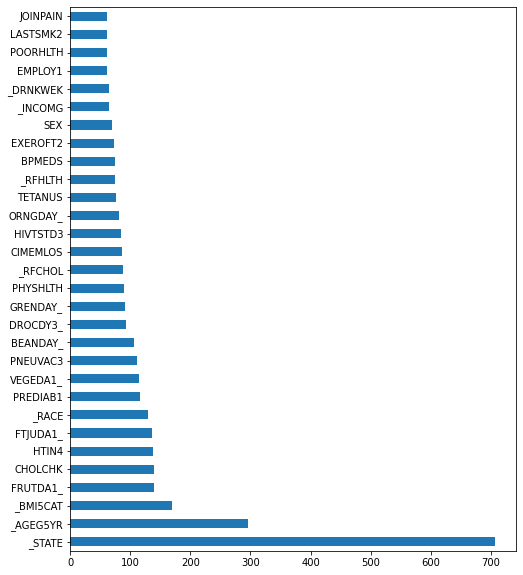

In [ ]:
feat_imp = pd.Series(model_lgb.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [ ]:
#saving
x = feat_imp.nlargest(25).index
features = df[x]

In [ ]:
#saving
x = ['_STATE',	'PREDIAB1',	'_AGEG5YR',	'_BMI5CAT',	'BPMEDS',	'_RFHLTH',	'FTJUDA1_',	'PNEUVAC3',	'_RACE',	'CHOLCHK',	'_RFCHOL',	'HTIN4',	'CIMEMLOS',	'DROCDY3_',	'FRUTDA1_',	'CHCKIDNY',	'PHYSHLTH',	'SEX',	'SHINGLE2',	'VEGEDA1_',	'GRENDAY_',	'LASTSMK2',	'IMFVPLAC',	'EMPLOY1',	'WTCHSALT']
features = df[x]
features

,_STATE,PREDIAB1,_AGEG5YR,_BMI5CAT,BPMEDS,_RFHLTH,FTJUDA1_,PNEUVAC3,_RACE,CHOLCHK,_RFCHOL,HTIN4,CIMEMLOS,DROCDY3_,FRUTDA1_,CHCKIDNY,PHYSHLTH,SEX,SHINGLE2,VEGEDA1_,GRENDAY_,LASTSMK2,IMFVPLAC,EMPLOY1,WTCHSALT
0,1.0,3.0,9.0,4.0,1.0,2.0,1.700000e+01,1.0,1.0,1.0,2.0,70.0,9.0,5.397605e-79,3.300000e+01,2.0,15.0,2.0,9.0,100.0,3.300000e+01,2.0,1.0,8.0,9.0
1,1.0,3.0,7.0,3.0,9.0,1.0,7.000000e+00,2.0,1.0,4.0,1.0,68.0,1.0,5.397605e-79,1.700000e+01,2.0,88.0,2.0,9.0,13.0,2.900000e+01,99.0,99.0,3.0,2.0
2,1.0,3.0,11.0,2.0,9.0,2.0,9.999000e+04,9.0,1.0,1.0,2.0,71.0,9.0,9.000000e+02,9.999000e+04,2.0,15.0,2.0,9.0,99990.0,9.999000e+04,99.0,99.0,7.0,9.0
3,1.0,3.0,9.0,3.0,1.0,2.0,5.397605e-79,1.0,1.0,1.0,2.0,67.0,1.0,5.397605e-79,1.000000e+02,2.0,30.0,2.0,9.0,14.0,3.000000e+00,99.0,5.0,8.0,2.0
4,1.0,3.0,9.0,2.0,9.0,2.0,9.999000e+04,1.0,1.0,1.0,1.0,64.0,2.0,5.397605e-79,2.000000e+02,2.0,20.0,2.0,9.0,67.0,5.700000e+01,99.0,99.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,9.0,11.0,1.0,1.0,2.0,2.900000e+01,2.0,8.0,1.0,2.0,63.0,2.0,5.397605e-79,5.397605e-79,2.0,88.0,2.0,9.0,14.0,5.397605e-79,99.0,99.0,7.0,1.0
441452,72.0,9.0,2.0,3.0,9.0,1.0,1.700000e+01,2.0,8.0,1.0,1.0,63.0,9.0,5.397605e-79,1.000000e+02,2.0,88.0,2.0,9.0,29.0,1.000000e+01,99.0,99.0,1.0,1.0
441453,72.0,9.0,11.0,4.0,1.0,2.0,9.999000e+04,9.0,8.0,1.0,2.0,65.0,9.0,7.000000e+00,9.999000e+04,2.0,88.0,2.0,9.0,99990.0,9.999000e+04,7.0,99.0,7.0,9.0
441454,72.0,9.0,7.0,2.0,1.0,1.0,1.000000e+02,2.0,8.0,1.0,1.0,71.0,2.0,5.397605e-79,1.000000e+02,2.0,88.0,1.0,9.0,3.0,2.900000e+01,99.0,99.0,3.0,1.0


Now, let's convert the features with scientific notations to normal numbers.

In [ ]:
features['FTJUDA1_'] = features['FTJUDA1_'].round()
features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,_STATE,PREDIAB1,_AGEG5YR,_BMI5CAT,BPMEDS,_RFHLTH,FTJUDA1_,PNEUVAC3,_RACE,CHOLCHK,_RFCHOL,HTIN4,CIMEMLOS,DROCDY3_,FRUTDA1_,CHCKIDNY,PHYSHLTH,SEX,SHINGLE2,VEGEDA1_,GRENDAY_,LASTSMK2,IMFVPLAC,EMPLOY1,WTCHSALT
0,1.0,3.0,9.0,4.0,1.0,2.0,17.0,1.0,1.0,1.0,2.0,70.0,9.0,5.397605e-79,3.300000e+01,2.0,15.0,2.0,9.0,100.0,3.300000e+01,2.0,1.0,8.0,9.0
1,1.0,3.0,7.0,3.0,9.0,1.0,7.0,2.0,1.0,4.0,1.0,68.0,1.0,5.397605e-79,1.700000e+01,2.0,88.0,2.0,9.0,13.0,2.900000e+01,99.0,99.0,3.0,2.0
2,1.0,3.0,11.0,2.0,9.0,2.0,99990.0,9.0,1.0,1.0,2.0,71.0,9.0,9.000000e+02,9.999000e+04,2.0,15.0,2.0,9.0,99990.0,9.999000e+04,99.0,99.0,7.0,9.0
3,1.0,3.0,9.0,3.0,1.0,2.0,0.0,1.0,1.0,1.0,2.0,67.0,1.0,5.397605e-79,1.000000e+02,2.0,30.0,2.0,9.0,14.0,3.000000e+00,99.0,5.0,8.0,2.0
4,1.0,3.0,9.0,2.0,9.0,2.0,99990.0,1.0,1.0,1.0,1.0,64.0,2.0,5.397605e-79,2.000000e+02,2.0,20.0,2.0,9.0,67.0,5.700000e+01,99.0,99.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,9.0,11.0,1.0,1.0,2.0,29.0,2.0,8.0,1.0,2.0,63.0,2.0,5.397605e-79,5.397605e-79,2.0,88.0,2.0,9.0,14.0,5.397605e-79,99.0,99.0,7.0,1.0
441452,72.0,9.0,2.0,3.0,9.0,1.0,17.0,2.0,8.0,1.0,1.0,63.0,9.0,5.397605e-79,1.000000e+02,2.0,88.0,2.0,9.0,29.0,1.000000e+01,99.0,99.0,1.0,1.0
441453,72.0,9.0,11.0,4.0,1.0,2.0,99990.0,9.0,8.0,1.0,2.0,65.0,9.0,7.000000e+00,9.999000e+04,2.0,88.0,2.0,9.0,99990.0,9.999000e+04,7.0,99.0,7.0,9.0
441454,72.0,9.0,7.0,2.0,1.0,1.0,100.0,2.0,8.0,1.0,1.0,71.0,2.0,5.397605e-79,1.000000e+02,2.0,88.0,1.0,9.0,3.0,2.900000e+01,99.0,99.0,3.0,1.0


In [ ]:
features['GRENDAY_'] = features['GRENDAY_'].round()
features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,_STATE,PREDIAB1,_AGEG5YR,_BMI5CAT,BPMEDS,_RFHLTH,FTJUDA1_,PNEUVAC3,_RACE,CHOLCHK,_RFCHOL,HTIN4,CIMEMLOS,DROCDY3_,FRUTDA1_,CHCKIDNY,PHYSHLTH,SEX,SHINGLE2,VEGEDA1_,GRENDAY_,LASTSMK2,IMFVPLAC,EMPLOY1,WTCHSALT
0,1.0,3.0,9.0,4.0,1.0,2.0,17.0,1.0,1.0,1.0,2.0,70.0,9.0,5.397605e-79,3.300000e+01,2.0,15.0,2.0,9.0,100.0,33.0,2.0,1.0,8.0,9.0
1,1.0,3.0,7.0,3.0,9.0,1.0,7.0,2.0,1.0,4.0,1.0,68.0,1.0,5.397605e-79,1.700000e+01,2.0,88.0,2.0,9.0,13.0,29.0,99.0,99.0,3.0,2.0
2,1.0,3.0,11.0,2.0,9.0,2.0,99990.0,9.0,1.0,1.0,2.0,71.0,9.0,9.000000e+02,9.999000e+04,2.0,15.0,2.0,9.0,99990.0,99990.0,99.0,99.0,7.0,9.0
3,1.0,3.0,9.0,3.0,1.0,2.0,0.0,1.0,1.0,1.0,2.0,67.0,1.0,5.397605e-79,1.000000e+02,2.0,30.0,2.0,9.0,14.0,3.0,99.0,5.0,8.0,2.0
4,1.0,3.0,9.0,2.0,9.0,2.0,99990.0,1.0,1.0,1.0,1.0,64.0,2.0,5.397605e-79,2.000000e+02,2.0,20.0,2.0,9.0,67.0,57.0,99.0,99.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,9.0,11.0,1.0,1.0,2.0,29.0,2.0,8.0,1.0,2.0,63.0,2.0,5.397605e-79,5.397605e-79,2.0,88.0,2.0,9.0,14.0,0.0,99.0,99.0,7.0,1.0
441452,72.0,9.0,2.0,3.0,9.0,1.0,17.0,2.0,8.0,1.0,1.0,63.0,9.0,5.397605e-79,1.000000e+02,2.0,88.0,2.0,9.0,29.0,10.0,99.0,99.0,1.0,1.0
441453,72.0,9.0,11.0,4.0,1.0,2.0,99990.0,9.0,8.0,1.0,2.0,65.0,9.0,7.000000e+00,9.999000e+04,2.0,88.0,2.0,9.0,99990.0,99990.0,7.0,99.0,7.0,9.0
441454,72.0,9.0,7.0,2.0,1.0,1.0,100.0,2.0,8.0,1.0,1.0,71.0,2.0,5.397605e-79,1.000000e+02,2.0,88.0,1.0,9.0,3.0,29.0,99.0,99.0,3.0,1.0


In [ ]:
features['FRUTDA1_'] = features['FRUTDA1_'].round()
features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,_STATE,PREDIAB1,_AGEG5YR,_BMI5CAT,BPMEDS,_RFHLTH,FTJUDA1_,PNEUVAC3,_RACE,CHOLCHK,_RFCHOL,HTIN4,CIMEMLOS,DROCDY3_,FRUTDA1_,CHCKIDNY,PHYSHLTH,SEX,SHINGLE2,VEGEDA1_,GRENDAY_,LASTSMK2,IMFVPLAC,EMPLOY1,WTCHSALT
0,1.0,3.0,9.0,4.0,1.0,2.0,17.0,1.0,1.0,1.0,2.0,70.0,9.0,5.397605e-79,33.0,2.0,15.0,2.0,9.0,100.0,33.0,2.0,1.0,8.0,9.0
1,1.0,3.0,7.0,3.0,9.0,1.0,7.0,2.0,1.0,4.0,1.0,68.0,1.0,5.397605e-79,17.0,2.0,88.0,2.0,9.0,13.0,29.0,99.0,99.0,3.0,2.0
2,1.0,3.0,11.0,2.0,9.0,2.0,99990.0,9.0,1.0,1.0,2.0,71.0,9.0,9.000000e+02,99990.0,2.0,15.0,2.0,9.0,99990.0,99990.0,99.0,99.0,7.0,9.0
3,1.0,3.0,9.0,3.0,1.0,2.0,0.0,1.0,1.0,1.0,2.0,67.0,1.0,5.397605e-79,100.0,2.0,30.0,2.0,9.0,14.0,3.0,99.0,5.0,8.0,2.0
4,1.0,3.0,9.0,2.0,9.0,2.0,99990.0,1.0,1.0,1.0,1.0,64.0,2.0,5.397605e-79,200.0,2.0,20.0,2.0,9.0,67.0,57.0,99.0,99.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,9.0,11.0,1.0,1.0,2.0,29.0,2.0,8.0,1.0,2.0,63.0,2.0,5.397605e-79,0.0,2.0,88.0,2.0,9.0,14.0,0.0,99.0,99.0,7.0,1.0
441452,72.0,9.0,2.0,3.0,9.0,1.0,17.0,2.0,8.0,1.0,1.0,63.0,9.0,5.397605e-79,100.0,2.0,88.0,2.0,9.0,29.0,10.0,99.0,99.0,1.0,1.0
441453,72.0,9.0,11.0,4.0,1.0,2.0,99990.0,9.0,8.0,1.0,2.0,65.0,9.0,7.000000e+00,99990.0,2.0,88.0,2.0,9.0,99990.0,99990.0,7.0,99.0,7.0,9.0
441454,72.0,9.0,7.0,2.0,1.0,1.0,100.0,2.0,8.0,1.0,1.0,71.0,2.0,5.397605e-79,100.0,2.0,88.0,1.0,9.0,3.0,29.0,99.0,99.0,3.0,1.0


In [ ]:
features['DROCDY3_'] = features['DROCDY3_'].round()
features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,_STATE,PREDIAB1,_AGEG5YR,_BMI5CAT,BPMEDS,_RFHLTH,FTJUDA1_,PNEUVAC3,_RACE,CHOLCHK,_RFCHOL,HTIN4,CIMEMLOS,DROCDY3_,FRUTDA1_,CHCKIDNY,PHYSHLTH,SEX,SHINGLE2,VEGEDA1_,GRENDAY_,LASTSMK2,IMFVPLAC,EMPLOY1,WTCHSALT
0,1.0,3.0,9.0,4.0,1.0,2.0,17.0,1.0,1.0,1.0,2.0,70.0,9.0,0.0,33.0,2.0,15.0,2.0,9.0,100.0,33.0,2.0,1.0,8.0,9.0
1,1.0,3.0,7.0,3.0,9.0,1.0,7.0,2.0,1.0,4.0,1.0,68.0,1.0,0.0,17.0,2.0,88.0,2.0,9.0,13.0,29.0,99.0,99.0,3.0,2.0
2,1.0,3.0,11.0,2.0,9.0,2.0,99990.0,9.0,1.0,1.0,2.0,71.0,9.0,900.0,99990.0,2.0,15.0,2.0,9.0,99990.0,99990.0,99.0,99.0,7.0,9.0
3,1.0,3.0,9.0,3.0,1.0,2.0,0.0,1.0,1.0,1.0,2.0,67.0,1.0,0.0,100.0,2.0,30.0,2.0,9.0,14.0,3.0,99.0,5.0,8.0,2.0
4,1.0,3.0,9.0,2.0,9.0,2.0,99990.0,1.0,1.0,1.0,1.0,64.0,2.0,0.0,200.0,2.0,20.0,2.0,9.0,67.0,57.0,99.0,99.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,9.0,11.0,1.0,1.0,2.0,29.0,2.0,8.0,1.0,2.0,63.0,2.0,0.0,0.0,2.0,88.0,2.0,9.0,14.0,0.0,99.0,99.0,7.0,1.0
441452,72.0,9.0,2.0,3.0,9.0,1.0,17.0,2.0,8.0,1.0,1.0,63.0,9.0,0.0,100.0,2.0,88.0,2.0,9.0,29.0,10.0,99.0,99.0,1.0,1.0
441453,72.0,9.0,11.0,4.0,1.0,2.0,99990.0,9.0,8.0,1.0,2.0,65.0,9.0,7.0,99990.0,2.0,88.0,2.0,9.0,99990.0,99990.0,7.0,99.0,7.0,9.0
441454,72.0,9.0,7.0,2.0,1.0,1.0,100.0,2.0,8.0,1.0,1.0,71.0,2.0,0.0,100.0,2.0,88.0,1.0,9.0,3.0,29.0,99.0,99.0,3.0,1.0


Now, let's add the target variable to the features dataset and prepare for target encoding.

In [ ]:
target = df['TYPE2']
features = features.join(target)
features

,_STATE,PREDIAB1,_AGEG5YR,_BMI5CAT,BPMEDS,_RFHLTH,FTJUDA1_,PNEUVAC3,_RACE,CHOLCHK,_RFCHOL,HTIN4,CIMEMLOS,DROCDY3_,FRUTDA1_,CHCKIDNY,PHYSHLTH,SEX,SHINGLE2,VEGEDA1_,GRENDAY_,LASTSMK2,IMFVPLAC,EMPLOY1,WTCHSALT,TYPE2
0,1.0,3.0,9.0,4.0,1.0,2.0,17.0,1.0,1.0,1.0,2.0,70.0,9.0,0.0,33.0,2.0,15.0,2.0,9.0,100.0,33.0,2.0,1.0,8.0,9.0,0
1,1.0,3.0,7.0,3.0,9.0,1.0,7.0,2.0,1.0,4.0,1.0,68.0,1.0,0.0,17.0,2.0,88.0,2.0,9.0,13.0,29.0,99.0,99.0,3.0,2.0,0
2,1.0,3.0,11.0,2.0,9.0,2.0,99990.0,9.0,1.0,1.0,2.0,71.0,9.0,900.0,99990.0,2.0,15.0,2.0,9.0,99990.0,99990.0,99.0,99.0,7.0,9.0,0
3,1.0,3.0,9.0,3.0,1.0,2.0,0.0,1.0,1.0,1.0,2.0,67.0,1.0,0.0,100.0,2.0,30.0,2.0,9.0,14.0,3.0,99.0,5.0,8.0,2.0,0
4,1.0,3.0,9.0,2.0,9.0,2.0,99990.0,1.0,1.0,1.0,1.0,64.0,2.0,0.0,200.0,2.0,20.0,2.0,9.0,67.0,57.0,99.0,99.0,8.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,72.0,9.0,11.0,1.0,1.0,2.0,29.0,2.0,8.0,1.0,2.0,63.0,2.0,0.0,0.0,2.0,88.0,2.0,9.0,14.0,0.0,99.0,99.0,7.0,1.0,1
441452,72.0,9.0,2.0,3.0,9.0,1.0,17.0,2.0,8.0,1.0,1.0,63.0,9.0,0.0,100.0,2.0,88.0,2.0,9.0,29.0,10.0,99.0,99.0,1.0,1.0,0
441453,72.0,9.0,11.0,4.0,1.0,2.0,99990.0,9.0,8.0,1.0,2.0,65.0,9.0,7.0,99990.0,2.0,88.0,2.0,9.0,99990.0,99990.0,7.0,99.0,7.0,9.0,0
441454,72.0,9.0,7.0,2.0,1.0,1.0,100.0,2.0,8.0,1.0,1.0,71.0,2.0,0.0,100.0,2.0,88.0,1.0,9.0,3.0,29.0,99.0,99.0,3.0,1.0,0


Now, we will convert the selected features into categorical values in preparation for target encoding. To do this, let's first identify how each feature's observations are labeled and organized to determine how best to transform them.

In [ ]:
features.dtypes

_STATE      float64
PREDIAB1    float64
_AGEG5YR    float64
_BMI5CAT    float64
BPMEDS      float64
_RFHLTH     float64
FTJUDA1_    float64
PNEUVAC3    float64
_RACE       float64
CHOLCHK     float64
_RFCHOL     float64
HTIN4       float64
CIMEMLOS    float64
DROCDY3_    float64
FRUTDA1_    float64
CHCKIDNY    float64
PHYSHLTH    float64
SEX         float64
SHINGLE2    float64
VEGEDA1_    float64
GRENDAY_    float64
LASTSMK2    float64
IMFVPLAC    float64
EMPLOY1     float64
WTCHSALT    float64
TYPE2         int64
dtype: object

In [ ]:
#grab features as pandas series
state = features['_STATE']
prediabetes = features['PREDIAB1']
age = features['_AGEG5YR']
weight = features['_BMI5CAT']
blood_pressure_meds = features['BPMEDS']
general_health = features['_RFHLTH']
fruit_juice = features['FTJUDA1_']
pneumonia_shot = features['PNEUVAC3']
race = features['_RACE']
cholesterol_check = features['CHOLCHK']
high_cholesterol = features['_RFCHOL']
height = features['HTIN4']
cognitive_decline = features['CIMEMLOS']
alcohol = features['DROCDY3_']
fruit = features['FRUTDA1_']
kidney_health = features['CHCKIDNY']
physical_health = features['PHYSHLTH']
sex = features['SEX']
shingles_vaccine = features['SHINGLE2']
other_veg = features['VEGEDA1_']
green_veg = features['GRENDAY_']
cigarettes = features['LASTSMK2']
flushot_location = features['IMFVPLAC']
employment = features['EMPLOY1']
sodium = features['WTCHSALT']
type2_diabetes = features['TYPE2']

## replace values

The 2015 BRFSS Codebook was used to explore and understand how each of the selected features values were coded. This information was then used to convert all feature observations to categorical values in preparation for target encoding in the next steps.

Note: In order to use this string values as feature_names in future steps, we must not have any whitespace within the string value itself. Therefore, "West Virginia" must be coded as "West-Virginia".

In [ ]:
state_replace = {1:'Alabama', 2:'Alaska',4:'Arizona',5: 'Arkansas',6:'California',8:'Colorado',9:'Connecticut',10: 'Delaware',11: 'District-of-Columbia',12: 'Florida',13: 'Georgia',15: 'Hawaii',16: 'Idaho',17: 'Illinois',18: 'Indiana',19: 'Iowa',20: 'Kansas',21: 'Kentucky',22: 'Louisiana',23: 'Maine',24: 'Maryland',25: 'Massachusetts',26: 'Michigan',27: 'Minnesota',28: 'Mississippi',29: 'Missouri',30: 'Montana',31: 'Nebraska',32: 'Nevada',33: 'New-Hampshire',34: 'New-Jersey',35: 'New-Mexico',36: 'New-York',37: 'North-Carolina',38: 'North-Dakota',39: 'Ohio',40: 'Oklahoma',41: 'Oregon',42: 'Pennsylvania',44: 'Rhode-Island',45: 'South-Carolina',46: 'South-Dakota',47: 'Tennessee',48: 'Texas',49: 'Utah',50: 'Vermont',51: 'Virginia',53: 'Washington',54: 'West-Virginia',55: 'Wisconsin',56: 'Wyoming',66: 'Guam',72: 'Puerto-Rico'}

In [ ]:
prediabetes_replace = {1:'yes',2:'yes-while-pregnant',3:'no',7:'idk',9:'refused'}

In [ ]:
age_replace = {1:'18-24', 2:'25-29', 3:'30-34', 4:'35-39', 5:'40-44', 6:'45-49', 7:'50-54', 8:'55-59', 9:'60-64', 10:'65-69', 11:'70-74', 12:'75-79', 13:'80+', 14:'idk-refused'}

In [ ]:
weight_replace = {1:'underweight',2:'normal-weight',3:'overweight',4:'obese',9999:'idk-refused'}

In [ ]:
blood_pressure_meds_replace = {1:'yes',2:'no',7:'idk',9:'refused'}

In [ ]:
general_health_replace = {1:'good-health',2:'poor-health',9:'refused'}

In [ ]:
#fruit juice intake
criteria = [fruit_juice.between(0, 1), fruit_juice.between(2, 500), fruit_juice.between(501, 1000), fruit_juice.between(1001, 1500),fruit_juice.between(1501, 2000),fruit_juice.between(2001, 9000)]
values = ['no','1-500', '501-1000', '1001-1500','1501-2000','2001-9000']

fruit_juice = np.select(criteria, values, 'idk-refused')
fruit_juice

array(['1-500', '1-500', 'idk-refused', ..., 'idk-refused', '1-500',
       '1-500'], dtype='<U11')

In [ ]:
fruit_juice = pd.Series(fruit_juice)
fruit_juice.value_counts()

1-500          236708
no             165937
idk-refused     38538
501-1000          229
1001-1500          20
1501-2000          13
2001-9000          11
dtype: int64

In [ ]:
pneumonia_shot_replace = {1:'yes',2:'no',7:'idk',9:'refused'}

In [ ]:
race_replace = {1:'white', 2:'black', 3:'native-american', 4:'asian', 5:'hawaiian/pacific-islander', 6:'other', 7:'multiracial', 8:'hispanic', 9:'refused'}

In [ ]:
cholesterol_check_replace = {1:'<1year', 2:'1>2years', 3:'2>5years', 4:'>5years',7:'idk',9:'refused'}

In [ ]:
high_cholesterol_replace = {1:'no',2:'yes',9:'idk-refused'}

In [ ]:
#height in inches
criteria = [height.between(30, 40), height.between(41, 50), height.between(51, 60), height.between(61, 70), height.between(71, 80), height.between(81, 90),height.between(91, 100)]
values = ['30-40','41-50', '51-60', '61-70','71-80','81-90','91-100']

height = np.select(criteria, values, 'idk-refused')
height

array(['61-70', '61-70', '71-80', ..., '61-70', '71-80', '61-70'],
      dtype='<U11')

In [ ]:
height = pd.Series(height)
height.value_counts()

61-70          315284
71-80           85615
51-60           22940
idk-refused     17260
41-50             175
81-90             173
30-40               7
91-100              2
dtype: int64

In [ ]:
cognitive_decline_replace = {1:'yes',2:'no',7:'idk',9:'refused'}

In [ ]:
#alcohol consumption
criteria = [alcohol.between(0, 2), alcohol.between(3, 25), alcohol.between(26, 50), alcohol.between(51, 100)]
values = ['no','1-25', '26-50', '51-100']

alcohol = np.select(criteria, values, 'idk-refused')
alcohol

array(['no', 'no', 'idk-refused', ..., '1-25', 'no', 'no'], dtype='<U11')

In [ ]:
alcohol = pd.Series(alcohol)
alcohol.value_counts()

no             208460
1-25           120808
51-100          46116
26-50           44422
idk-refused     21650
dtype: int64

In [ ]:
#fruit intake
criteria = [fruit.between(0, 1), fruit.between(2, 500), fruit.between(501, 1000), fruit.between(1001, 2000),fruit.between(2001, 3000),fruit.between(3001, 4000),fruit.between(4001, 5000),fruit.between(5001, 6000),fruit.between(6001, 7000),fruit.between(7001, 9900)]
values = ['no','1-500', '501-1000', '1001-2000','2001-3000','3001-4000','4001-5000','5001-6000','6001-7000','7001-9900']

fruit = np.select(criteria, values, 'idk-refused')
fruit

array(['1-500', '1-500', 'idk-refused', ..., 'idk-refused', '1-500',
       '1-500'], dtype='<U11')

In [ ]:
fruit = pd.Series(fruit)
fruit.value_counts()

1-500          387881
idk-refused     36582
no              16204
501-1000          703
1001-2000          40
2001-3000          25
7001-9900          16
4001-5000           3
3001-4000           1
5001-6000           1
dtype: int64

In [ ]:
kidney_health_replace = {1:'yes',2:'no',7:'idk',9:'refused'}

In [ ]:
#amount of physical exercise 
criteria = [physical_health.between(1, 5), physical_health.between(6, 10), physical_health.between(11, 15), physical_health.between(16, 20),physical_health.between(21, 25),physical_health.between(26, 30), physical_health.between(81, 88)]
values = ['1-5','6-10', '11-15', '16-20','21-25','26-30','no']

physical_health = np.select(criteria, values, 'idk-refused')
physical_health

array(['11-15', 'no', '11-15', ..., 'no', 'no', 'no'], dtype='<U11')

In [ ]:
physical_health = pd.Series(physical_health)
physical_health.value_counts()

no             274143
1-5             76890
26-30           35770
6-10            21149
11-15           14022
idk-refused      9743
16-20            6117
21-25            3622
dtype: int64

In [ ]:
sex_replace = {1:'male', 2:'female'}

In [ ]:
shingles_vaccine_replace = {1:'yes',2:'no',7:'idk',9:'refused'}

In [ ]:
#other than dark green vegetables intake
criteria = [other_veg.between(0, 1), other_veg.between(2, 500), other_veg.between(501, 1000), other_veg.between(1001, 2000),other_veg.between(2001, 3000),other_veg.between(3001, 4000),other_veg.between(4001, 5000),other_veg.between(5001, 6000),other_veg.between(6001, 7000),other_veg.between(7001, 8000),other_veg.between(8001, 9900)]
values = ['no','1-500', '501-1000', '1001-2000','2001-3000','3001-4000','4001-5000','5001-6000','6001-7000','7001-8000','8001-9900']

other_veg = np.select(criteria, values, 'idk-refused')
other_veg

array(['1-500', '1-500', 'idk-refused', ..., 'idk-refused', '1-500',
       '1-500'], dtype='<U11')

In [ ]:
other_veg = pd.Series(other_veg)
other_veg.value_counts()

1-500          392199
idk-refused     41463
no               7452
501-1000          295
1001-2000          25
2001-3000          12
8001-9900           6
7001-8000           2
3001-4000           2
dtype: int64

In [ ]:
#dark green vegetable intake
criteria = [green_veg.between(0, 1), green_veg.between(2, 100), green_veg.between(101,500),green_veg.between(501, 1000), green_veg.between(1001, 2000),green_veg.between(2001, 3000),green_veg.between(3001, 4000),green_veg.between(4001, 5000),green_veg.between(5001, 6000),green_veg.between(6001, 7000),green_veg.between(7001, 8000),green_veg.between(8001, 9900)]
values = ['no','1-100','101-500', '501-1000', '1001-2000','2001-3000','3001-4000','4001-5000','5001-6000','6001-7000','7001-8000','8001-9900']

green_veg = np.select(criteria, values, 'idk-refused')
green_veg

array(['1-100', '1-100', 'idk-refused', ..., 'idk-refused', '1-100',
       '1-100'], dtype='<U11')

In [ ]:
green_veg = pd.Series(green_veg)
green_veg.value_counts()

1-100          347433
idk-refused     37949
no              31418
101-500         24453
501-1000          174
1001-2000          15
2001-3000           9
7001-8000           2
8001-9900           2
3001-4000           1
dtype: int64

In [ ]:
cigarettes_replace = {1:'<1month',2:'1m>3months',3:'3m>6months',4:'6m>1year',5:'1y>5years',6:'5y>10years',7:'>10years',8:'no',77:'idk',99:'refused'}

In [ ]:
flushot_location_replace = {1:'dr-office/HMO',2:'health-dept',3:'clinic/health-cntr',4:'senior-cntr',5:'store',6:'hospital',7:'er',8:'workplace',9:'other',10:'Canada/Mexico',11:'school',77:'idk',99:'refused'}

In [ ]:
employment_replace = {1:'employed-for-wages',2:'self-employed', 3:'out-of-work>1year',4:'out-of-work<1year',5:'homemaker',6:'student',7:'retired',8:'unable-to-work',9:'idk-refused'}

In [ ]:
sodium_replace = {1:'yes',2:'no',7:'idk',9:'refused'}

Replace new categorical labeling over old data

In [ ]:
state = state.replace(state_replace)
prediabetes = prediabetes.replace(prediabetes_replace)
age = age.replace(age_replace)
weight = weight.replace(weight_replace)
blood_pressure_meds = blood_pressure_meds.replace(blood_pressure_meds_replace)
general_health = general_health.replace(general_health_replace)
fruit_juice #already changed
pneumonia_shot = pneumonia_shot.replace(pneumonia_shot_replace)
race = race.replace(race_replace)
cholesterol_check = cholesterol_check.replace(cholesterol_check_replace)
high_cholesterol = high_cholesterol.replace(high_cholesterol_replace)
height #already replaced
cognitive_decline = cognitive_decline.replace(cognitive_decline_replace)
alcohol #already replaced
fruit #already replaced
kidney_health = kidney_health.replace(kidney_health_replace)
physical_health #already replaced
sex = sex.replace(sex_replace)
shingles_vaccine = shingles_vaccine.replace(shingles_vaccine_replace)
other_veg #already replaced
green_veg #already replaced
cigarettes = cigarettes.replace(cigarettes_replace)
flushot_location = flushot_location.replace(flushot_location_replace)
employment = employment.replace(employment_replace)
sodium = sodium.replace(sodium_replace)

Now, put this categorical data back into a single dataframe

In [ ]:
categorical_df = pd.concat([state,prediabetes,age,weight,blood_pressure_meds,general_health,fruit_juice,pneumonia_shot,race,cholesterol_check,high_cholesterol,height,cognitive_decline,alcohol,fruit,kidney_health,physical_health,sex,shingles_vaccine,other_veg,green_veg,cigarettes,employment,sodium,type2_diabetes], axis=1)
categorical_df.columns = ['state','prediabetes','age','weight','blood_pressure_meds','general_health','fruit_juice','pneumonia_shot','race','cholesterol_check','high_cholesterol','height','cognitive_decline','alcohol','fruit','kidney_health','physical_health','sex','shingles_vaccine','other_veg','green_veg','cigarettes','employment','sodium','type2_diabetes']
categorical_df

,state,prediabetes,age,weight,blood_pressure_meds,general_health,fruit_juice,pneumonia_shot,race,cholesterol_check,high_cholesterol,height,cognitive_decline,alcohol,fruit,kidney_health,physical_health,sex,shingles_vaccine,other_veg,green_veg,cigarettes,employment,sodium,type2_diabetes
0,Alabama,no,60-64,obese,yes,poor-health,1-500,yes,white,<1year,yes,61-70,refused,no,1-500,no,11-15,female,refused,1-500,1-100,1m>3months,unable-to-work,refused,0
1,Alabama,no,50-54,overweight,refused,good-health,1-500,no,white,>5years,no,61-70,yes,no,1-500,no,no,female,refused,1-500,1-100,refused,out-of-work>1year,no,0
2,Alabama,no,70-74,normal-weight,refused,poor-health,idk-refused,refused,white,<1year,yes,71-80,refused,idk-refused,idk-refused,no,11-15,female,refused,idk-refused,idk-refused,refused,retired,refused,0
3,Alabama,no,60-64,overweight,yes,poor-health,no,yes,white,<1year,yes,61-70,yes,no,1-500,no,26-30,female,refused,1-500,1-100,refused,unable-to-work,no,0
4,Alabama,no,60-64,normal-weight,refused,poor-health,idk-refused,yes,white,<1year,no,61-70,no,no,1-500,no,16-20,female,refused,1-500,1-100,refused,unable-to-work,yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,Puerto-Rico,refused,70-74,underweight,yes,poor-health,1-500,no,hispanic,<1year,yes,61-70,no,no,no,no,no,female,refused,1-500,no,refused,retired,yes,1
441452,Puerto-Rico,refused,25-29,overweight,refused,good-health,1-500,no,hispanic,<1year,no,61-70,refused,no,1-500,no,no,female,refused,1-500,1-100,refused,employed-for-wages,yes,0
441453,Puerto-Rico,refused,70-74,obese,yes,poor-health,idk-refused,refused,hispanic,<1year,yes,61-70,refused,1-25,idk-refused,no,no,female,refused,idk-refused,idk-refused,>10years,retired,refused,0
441454,Puerto-Rico,refused,50-54,normal-weight,yes,good-health,1-500,no,hispanic,<1year,no,71-80,no,no,1-500,no,no,male,refused,1-500,1-100,refused,out-of-work>1year,yes,0


# Target encoding

Target encoding is the process of replacing a categorical value with the mean of the target variable. Any non-categorical columns are automatically dropped by the target encoder model.

You can also use target encoding to convert categorical columns to numeric, which we will use it for in this section. This can help improve machine learning accuracy since algorithms tend to have a hard time dealing with high cardinality columns (features with a large number of categories). 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
#transformer class to perform target encoding

class TargetEncoder(BaseEstimator, TransformerMixin):
    """Target encoder.
    
    Replaces categorical column(s) with the mean target value for
    each category.

    """
    
    def __init__(self, cols=None):
        """Target encoder
        
        Parameters
        ----------
        cols : list of str
            Columns to target encode.  Default is to target 
            encode all categorical columns in the DataFrame.
        """
        if isinstance(cols, str):
            self.cols = [cols]
        else:
            self.cols = cols
        
        
    def fit(self, X, y):
        """Fit target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """

        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [col for col in X 
                         if str(X[col].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')

        # Encode each element of each column
        self.maps = dict() #dict to store map for each column
        for col in self.cols:
            tmap = dict()
            uniques = X[col].unique()
            for unique in uniques:
                tmap[unique] = y[X[col]==unique].mean()
            self.maps[col] = tmap
            
        return self

        
    def transform(self, X, y=None):
        """Perform the target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        Xo = X.copy()
        for col, tmap in self.maps.items():
            vals = np.full(X.shape[0], np.nan)
            for val, mean_target in tmap.items():
                vals[X[col]==val] = mean_target
            Xo[col] = vals
        return Xo
            
            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y)

In [ ]:
X = categorical_df.iloc[:,: -1]
y = categorical_df.iloc[:,-1:]

X_test,y_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
!pip install category_encoders
import category_encoders as ce
encoder = ce.TargetEncoder()
encoded_features = encoder.fit_transform(X, y)

     |████████████████████████████████| 80 kB 5.0 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
encoded_features

,state,prediabetes,age,weight,blood_pressure_meds,general_health,fruit_juice,pneumonia_shot,race,cholesterol_check,high_cholesterol,height,cognitive_decline,alcohol,fruit,kidney_health,physical_health,sex,shingles_vaccine,other_veg,green_veg,cigarettes,employment,sodium
0,0.169308,0.000000,0.171908,0.230504,0.266355,0.296992,0.112202,0.212869,0.119337,0.173159,0.225517,0.128326,0.111739,0.180150,0.128318,0.119388,0.214877,0.123972,0.124384,0.128453,0.127072,0.097530,0.292054,0.125268
1,0.169308,0.000000,0.113061,0.115439,0.053195,0.089652,0.112202,0.076920,0.119337,0.027878,0.083594,0.128326,0.264431,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.134980,0.098757
2,0.169308,0.000000,0.218732,0.056077,0.053195,0.296992,0.122087,0.119395,0.119337,0.173159,0.225517,0.122700,0.111739,0.113072,0.123804,0.119388,0.214877,0.123972,0.124384,0.125341,0.123034,0.113719,0.200757,0.125268
3,0.169308,0.000000,0.171908,0.115439,0.266355,0.296992,0.153444,0.212869,0.119337,0.173159,0.225517,0.128326,0.264431,0.180150,0.128318,0.119388,0.277691,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.098757
4,0.169308,0.000000,0.171908,0.056077,0.053195,0.296992,0.122087,0.212869,0.119337,0.173159,0.083594,0.128326,0.164604,0.180150,0.128318,0.119388,0.256335,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.198241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,0.201110,0.158186,0.218732,0.043446,0.266355,0.296992,0.112202,0.076920,0.140718,0.173159,0.225517,0.128326,0.164604,0.180150,0.147186,0.119388,0.094261,0.123972,0.124384,0.128453,0.175950,0.113719,0.200757,0.198241
441452,0.201110,0.158186,0.000000,0.115439,0.053195,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.128326,0.111739,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.070031,0.198241
441453,0.201110,0.158186,0.218732,0.230504,0.266355,0.296992,0.122087,0.119395,0.140718,0.173159,0.225517,0.128326,0.111739,0.093876,0.123804,0.119388,0.094261,0.123972,0.124384,0.125341,0.123034,0.189050,0.200757,0.125268
441454,0.201110,0.158186,0.113061,0.056077,0.266355,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.122700,0.164604,0.180150,0.128318,0.119388,0.094261,0.134777,0.124384,0.128453,0.127072,0.113719,0.134980,0.198241


Now, we have encoded our 24 features. Note that the size of our target-encoded matrix is the same size as the original:

In [ ]:
# Compare sizes
print('Original size:', X.shape)
print('Target encoded size:', encoded_features.shape)

Original size: (441456, 24)
Target encoded size: (441456, 24)


In [ ]:
# Compare category counts
print('Original:')
print(X.nunique())
print('\nTarget encoded:')
print(encoded_features.nunique())

Original:
state                  53
prediabetes             5
age                    14
weight                  5
blood_pressure_meds     4
general_health          3
fruit_juice             7
pneumonia_shot          4
race                    9
cholesterol_check       6
high_cholesterol        3
height                  8
cognitive_decline       4
alcohol                 5
fruit                  10
kidney_health           4
physical_health         8
sex                     2
shingles_vaccine        4
other_veg               9
green_veg              10
cigarettes             10
employment              9
sodium                  4
dtype: int64

Target encoded:
state                  53
prediabetes             2
age                    13
weight                  5
blood_pressure_meds     4
general_health          3
fruit_juice             7
pneumonia_shot          4
race                    9
cholesterol_check       6
high_cholesterol        3
height                  8
cognitive_decline       

Right away, we notice that the parameter `prediabetes` has reduced from 5 categories to 2, `age` reduced from 14 to 13, `fruit` reduced from 10 to 9, `other_veg` reduced from 9 to 8 and `green_veg` reduced from 10 to 9. Therefore, we will have to explore what is occuring here, but first we need to join the target feature to the new encoded dataset.

## join target variable to encoded_features df

In [ ]:
x = categorical_df['type2_diabetes']
encoded_features = encoded_features.join(x)
encoded_features

,state,prediabetes,age,weight,blood_pressure_meds,general_health,fruit_juice,pneumonia_shot,race,cholesterol_check,high_cholesterol,height,cognitive_decline,alcohol,fruit,kidney_health,physical_health,sex,shingles_vaccine,other_veg,green_veg,cigarettes,employment,sodium,type2_diabetes
0,0.169308,0.000000,0.171908,0.230504,0.266355,0.296992,0.112202,0.212869,0.119337,0.173159,0.225517,0.128326,0.111739,0.180150,0.128318,0.119388,0.214877,0.123972,0.124384,0.128453,0.127072,0.097530,0.292054,0.125268,0
1,0.169308,0.000000,0.113061,0.115439,0.053195,0.089652,0.112202,0.076920,0.119337,0.027878,0.083594,0.128326,0.264431,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.134980,0.098757,0
2,0.169308,0.000000,0.218732,0.056077,0.053195,0.296992,0.122087,0.119395,0.119337,0.173159,0.225517,0.122700,0.111739,0.113072,0.123804,0.119388,0.214877,0.123972,0.124384,0.125341,0.123034,0.113719,0.200757,0.125268,0
3,0.169308,0.000000,0.171908,0.115439,0.266355,0.296992,0.153444,0.212869,0.119337,0.173159,0.225517,0.128326,0.264431,0.180150,0.128318,0.119388,0.277691,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.098757,0
4,0.169308,0.000000,0.171908,0.056077,0.053195,0.296992,0.122087,0.212869,0.119337,0.173159,0.083594,0.128326,0.164604,0.180150,0.128318,0.119388,0.256335,0.123972,0.124384,0.128453,0.127072,0.113719,0.292054,0.198241,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441451,0.201110,0.158186,0.218732,0.043446,0.266355,0.296992,0.112202,0.076920,0.140718,0.173159,0.225517,0.128326,0.164604,0.180150,0.147186,0.119388,0.094261,0.123972,0.124384,0.128453,0.175950,0.113719,0.200757,0.198241,1
441452,0.201110,0.158186,0.000000,0.115439,0.053195,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.128326,0.111739,0.180150,0.128318,0.119388,0.094261,0.123972,0.124384,0.128453,0.127072,0.113719,0.070031,0.198241,0
441453,0.201110,0.158186,0.218732,0.230504,0.266355,0.296992,0.122087,0.119395,0.140718,0.173159,0.225517,0.128326,0.111739,0.093876,0.123804,0.119388,0.094261,0.123972,0.124384,0.125341,0.123034,0.189050,0.200757,0.125268,0
441454,0.201110,0.158186,0.113061,0.056077,0.266355,0.089652,0.112202,0.076920,0.140718,0.173159,0.083594,0.122700,0.164604,0.180150,0.128318,0.119388,0.094261,0.134777,0.124384,0.128453,0.127072,0.113719,0.134980,0.198241,0


## exploring overfitting

In [ ]:
#exploring prediabetes
encoded_features['prediabetes'].value_counts()

0.158186    358743
0.000000     82713
Name: prediabetes, dtype: int64

In [ ]:
#exploring age
encoded_features['age'].value_counts()

0.171908    49794
0.202927    49264
0.137376    46209
0.000000    43938
0.113061    39881
0.218732    38362
0.180033    36760
0.084555    30276
0.216775    28232
0.061021    25942
0.039927    24545
0.022691    22917
0.105322     5336
Name: age, dtype: int64

In [ ]:
#exploring fruit
encoded_features['fruit'].value_counts()

0.128318    387881
0.123804     36582
0.147186     16204
0.081081       703
0.000000        40
0.120000        25
0.125000        16
0.015323         3
0.128547         2
Name: fruit, dtype: int64

In [ ]:
#exploring other_veg
encoded_features['other_veg'].value_counts()

0.128453    392199
0.125341     41463
0.151369      7452
0.128814       295
0.080000        25
0.333330        12
0.000860         6
0.034572         4
Name: other_veg, dtype: int64

In [ ]:
#exploring green_veg
encoded_features['green_veg'].value_counts()

0.127072    347433
0.123034     37949
0.175950     31418
0.097616     24453
0.068966       174
0.200000        15
0.000043         9
0.034572         4
0.128547         1
Name: green_veg, dtype: int64

From this output we can see that an observation has been encoded as "0.0" for the first three features. When this occurs we know that TargetEncoding has overfit the variable and has caused target leakage. To fix this we will need to smooth the mean and treat the weight we will apply to the categories in this variable as a hyperparameter. For the last two, this isn't isn't target leakage, rather target encoding combined two categories with single observations into one category.

In [ ]:
#created a function to handle the smoothing of the mean calculations
def calc_smooth_mean(df1,df2,cat_var,target,weight):
  mean = df1[target].mean()

  agg = df1.groupby(cat_var)[target].agg(['count','mean'])
  counts = agg['count']
  means = agg['mean']

  smooth = (counts * means + weight * mean) / (counts + weight)

  if df2 is None:
    return df1[cat_var].map(smooth)
  else:
    return df1[cat_var].map(smooth),df2[cat_var.map(smooth.to_dict())]

In [ ]:
#values between 5 and 500,000 were tried before settling on 100,000 for the weight
WEIGHT = 100000
#replace feature with new weighted values
encoded_features['prediabetes']= calc_smooth_mean(df1=categorical_df, df2=None, cat_var='prediabetes',target='type2_diabetes',weight=WEIGHT)
encoded_features['prediabetes'].value_counts()

0.151725    358743
0.074352     72890
0.118422      8550
0.127297       982
0.128174       291
Name: prediabetes, dtype: int64

In [ ]:
WEIGHT = 5
encoded_features['age']= calc_smooth_mean(df1=categorical_df, df2=None, cat_var='age',target='type2_diabetes',weight=WEIGHT)
encoded_features['age'].value_counts()

0.171904    49794
0.202920    49264
0.137375    46209
0.113063    39881
0.218720    38362
0.180026    36760
0.084563    30276
0.216760    28232
0.061034    25942
0.039945    24545
0.000027    24192
0.022714    22917
0.000033    19746
0.105344     5336
Name: age, dtype: int64

In [ ]:
WEIGHT = 5
encoded_features['fruit']= calc_smooth_mean(df1=categorical_df, df2=None, cat_var='fruit',target='type2_diabetes',weight=WEIGHT)
encoded_features['fruit'].value_counts()

0.128318    387881
0.123805     36582
0.147180     16204
0.081416       703
0.014283        40
0.121425        25
0.125845        16
0.080342         3
0.107123         2
Name: fruit, dtype: int64

In [ ]:
# Compare category counts
print('Original:')
print(categorical_df.nunique())
print('\nTarget encoded:')
print(encoded_features.nunique())

Original:
state                  53
prediabetes             5
age                    14
weight                  5
blood_pressure_meds     4
general_health          3
fruit_juice             7
pneumonia_shot          4
race                    9
cholesterol_check       6
high_cholesterol        3
height                  8
cognitive_decline       4
alcohol                 5
fruit                  10
kidney_health           4
physical_health         8
sex                     2
shingles_vaccine        4
other_veg               9
green_veg              10
cigarettes             10
employment              9
sodium                  4
type2_diabetes          2
dtype: int64

Target encoded:
state                  53
prediabetes             5
age                    14
weight                  5
blood_pressure_meds     4
general_health          3
fruit_juice             7
pneumonia_shot          4
race                    9
cholesterol_check       6
high_cholesterol        3
height                  

# Save file (after final feature selection)

We have successfully reduced the dimensionality of the dataset by using the LGBM method to select the highest correlated features reducing the final dataset to 25 features (including the target variable) and applied the TargetEncoder( ) method to convert the categorical features into numerical values.  Now, let's save this dataset of encoded features and prepare for traing and modeling in the next notebook.

In [ ]:
#save as df
encoded_features.to_csv('/content/drive/MyDrive/SPRINGBOARD/CAPSTONE 3/BRFSS Data/Processed/finalfeats_2015.csv',index=False)